In [1]:
# Temporary hack, see https://github.com/poliastro/poliastro/issues/281
from IPython.display import HTML
HTML('<script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.1.10/require.min.js"></script>')

import numpy as np

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import functools

import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris

from poliastro.twobody.propagation import cowell
from poliastro.ephem import build_ephem_interpolant

from poliastro.core.util import norm
from poliastro.core.perturbations import (
    atmospheric_drag, third_body
)
from poliastro.bodies import Earth, Moon
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter, plot, OrbitPlotter3D

### Atmospheric drag ###
The poliastro package now has several commonly used natural perturbations. One of them is atmospheric drag! See how one can monitor decay of the near-Earth orbit over time using our new module poliastro.twobody.perturbations!

In [3]:
R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2).value

orbit = Orbit.circular(Earth, 250 * u.km)

# parameters of a body
C_D = 2.2  # dimentionless (any value would do)
A = ((np.pi / 4.0) * (u.m**2)).to(u.km**2).value  # km^2
m = 100  # kg
B = C_D * A / m

# parameters of the atmosphere
rho0 = Earth.rho0.to(u.kg / u.km**3).value  # kg/km^3
H0 = Earth.H0.to(u.km).value
tof = 100000  # s
plot_times = np.linspace(0, tof, 2000)
rr, vv = cowell(orbit, plot_times, ad=atmospheric_drag, R=R, C_D=C_D, A=A, m=m, H0=H0, rho0=rho0)

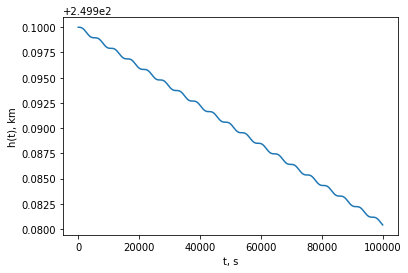

In [4]:
plt.ylabel('h(t), km')
plt.xlabel('t, s')
plt.plot(plot_times, [np.sqrt(np.sum(ri ** 2)) - R for ri in rr])

### 3rd body ###
Apart from time-independent perturbations such as atmospheric drag, J2/J3, we have time-dependend perturbations. Lets's see how Moon changes the orbit of GEO satellite over time!

In [5]:
moon_geo = {'body': Moon, 'tof': 60, 'raan': 6.0 * u.deg, 'argp': -11.0 * u.deg, 'inc': 6.5 * 1e-3 * u.deg,
            'orbit': [42164.0 * u.km, 0.0001 * u.one, 1 * u.deg, 0.0 * u.deg, 0.0 * u.deg, 0.0 * u.rad],
            'period': 28}

In [ ]:
body = moon_geo['body']
# database keeping positions of bodies in Solar system over time
solar_system_ephemeris.set('de432s')

j_date = 2454283.0
tof = (moon_geo['tof'] * u.day).to(u.s).value
# create interpolant of 3rd body coordinates (calling in on every iteration will be just too slow)
body_r = build_ephem_interpolant(body, moon_geo['period'], (j_date, j_date + moon_geo['tof']), rtol=1e-2)

epoch = Time(j_date, format='jd', scale='tdb')
initial = Orbit.from_classical(Earth, *moon_geo['orbit'], epoch=epoch)

cowell_with_3rdbody = functools.partial(cowell, rtol=1e-6, ad=third_body,
              k_third=400 * body.k.to(u.km**3 / u.s**2).value, third_body=body_r)

time_values = Time((np.linspace(0, tof, 1000) * u.s).to(u.day).value + j_date, format='jd', scale='tdb')
_, rr = initial.sample(time_values, method=cowell_with_3rdbody)

In [ ]:
frame = OrbitPlotter3D()

frame.set_attractor(Earth)
frame.plot_trajectory(rr, label='orbit influenced by Moon')
frame.show()

### Thrusts ###
Apart from natural perturbations, there are artificial thrusts aimed at intentional change of orbit parameters. One of such changes is simultaineous change of eccenricy and inclination.

In [ ]:
from poliastro.twobody.thrust import change_inc_ecc

ecc_0, ecc_f = 0.4, 0.0
a = 42164  # km
inc_0 = 0.0  # rad, baseline
inc_f = (20.0 * u.deg).to(u.rad).value  # rad
argp = 0.0  # rad, the method is efficient for 0 and 180
f = 2.4e-6  # km / s2

k = Earth.k.to(u.km**3 / u.s**2).value
s0 = Orbit.from_classical(
    Earth,
    a * u.km, ecc_0 * u.one, inc_0 * u.deg,
    0 * u.deg, argp * u.deg, 0 * u.deg,
    epoch=Time(0, format='jd', scale='tdb')
)
    
a_d, _, _, t_f = change_inc_ecc(s0, ecc_f, inc_f, f)

cowell_with_ad = functools.partial(cowell, rtol=1e-6, ad=a_d)

time_values = Time((np.linspace(0, t_f, 1000) * u.s).to(u.day).value, format='jd', scale='tdb')
_, rr = s0.sample(time_values, method=cowell_with_ad)

In [ ]:
frame = OrbitPlotter3D()

frame.set_attractor(Earth)
frame.plot_trajectory(rr, label='orbit with artificial thrust')
frame.show()